# Setup

In [ ]:
!pip install google-genai torch transformers

In [ ]:
GEMINI_API_KEY = "ENTER API KEY" #@param {type:"string"}

In [ ]:
from google import genai
from google.genai import types
import json
import time

client = genai.Client(api_key=GEMINI_API_KEY)

In [ ]:
import torch
from transformers import AutoTokenizer, Gemma3ForCausalLM

ckpt = "google/gemma-3-1b-pt"
tokenizer = AutoTokenizer.from_pretrained(ckpt)
model = Gemma3ForCausalLM.from_pretrained(
    ckpt,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


config.json:   0%|          | 0.00/880 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

# Dataset Generation

### Helper

In [ ]:
def student(history, topic_question, no_of_turns, current_turn, response_length, model='gemini-2.0-flash'):
  response_schema = {
    "type": "OBJECT",
    "properties": {
        "role": {
        "type": "string",
        "enum": ["student"]
        },
        "content": {
        "type": "string",
        }
    }
  }
  student_system_prompt = f"""
You are a freshman undergraduate student, who has enrolled as a volunteer in a program to determine if a tutor covers diverse perspectives or not.
You have to interact with a tutor regarding the following topic: {topic_question}.
You have to conduct {no_of_turns/2} rounds of conversation with the tutor. Each round comprises your response and the tutor's response. You begin with round 1.
You can ask the tutor questions or respond to the tutor.
The given topic / question only serves as a reference point for you. Based on this, you have to initiate the conversation. Throughout the conversation, you have to respond to the tutor. Ocassionally, you also have to ask questions and very occasionally make mistakes as well. The tutor does not have prior information about which topic you would like to learn about today.
Throughout x rounds of conversation, you can do one of the following things:
- Respond to the tutor.
- Ask about the topic.
- Have confusions about the topic.
- Clarifications about a tutor response.
- Asking the tutor to explore a sub-topic in detail. Do this only when the tutor doesn't initiate it themselves.
- Moving away from the given topic to a similar topic, to test if the tutor can link them together.
- Express doubts or lack of prerequisites.
Try asking about topics that may have multiple perspectives.
Your response shouldn't exceed {response_length} words. It can be significantly less than this limit, but never exceed it.
Don't add unnecessary tab spaces or new line commands in your response. This is a strict rule.
Keep your questions raw. Do not try to reiterate or clarify your question or response.
You only have to act as the student and not the tutor. Only ask questions and respond to the tutor. Do not overcomplicate things, keep your responses simple.
Whatever you ask or respond, keep it turn by turn; do not dump all of it at once.
Keep the conversation natural and similar to how a freshman would respond. You can decide the difficulty of questions as per the topic.
"""
  system = {"role": "system", "content": student_system_prompt+topic_question}
  new_history = []
  new_history.append(system)
  new_history.extend(history)
  if current_turn == 0:
    initial = {"role": "tutor", "content": "Hello there! I am your tutor. How can I help you today?"}
    new_history.append(initial)
  if model == 'gemini-2.0-flash':
    response = client.models.generate_content(
      model="gemini-2.0-flash",
      contents=json.dumps(new_history),
      config={
          'response_mime_type': 'application/json',
          'response_schema': response_schema,
      },
    )

    response = response.text
  else:
      model_inputs = tokenizer(f'{new_history}', return_tensors="pt").to(model.device)

      input_len = model_inputs["input_ids"].shape[-1]

      with torch.inference_mode():
          generation = model.generate(**model_inputs, max_new_tokens=50, do_sample=False)
          generation = generation[0][input_len:]

      response = tokenizer.decode(generation, skip_special_tokens=True)
  print("---------- STUDENT ----------")
  print(response)
  response = json.loads(response)
  return response

def tutor(history, tutor_response_length, current_turn, pedagogy=''):
  response_schema = {
    "type": "OBJECT",
    "properties": {
        "role": {
        "type": "string",
        "enum": ["tutor"]
        },
        "content": {
        "type": "string",
        }
    }
  }
  response_length_statement = f"{pedagogy}\n You can use any analogy or example of your choice only if necessary. \nRespond always in under {tutor_response_length} words. You can choose to respond to the student's question in significantly lower words that this limit, but never exceed this. Don't add unnecessary tab spaces or new line commands in your response. This is a strict rule."
  system = {"role": "system", "content": response_length_statement}
  new_history = []
  new_history.append(system)
  new_history.extend(history)
  response = client.models.generate_content(
    model="learnlm-2.0-flash-experimental",
    contents=json.dumps(new_history),
    config={
          'response_mime_type': 'application/json',
          'response_schema': response_schema,
    },
  )
  print("---------- TUTOR ----------")
  print(response.text)
  response = json.loads(response.text)
  return response

In [ ]:
def generate_conversation(topic_question, no_of_turns, tutor_response_length, student_response_length, pedagogy):
  current_turn = 0
  chat_history = []
  while current_turn < no_of_turns:
    print(f">>>>>>>>>> Round {int((current_turn/2)+1)} <<<<<<<<<<")
    student_response = student(chat_history, topic_question, no_of_turns, current_turn, student_response_length)
    chat_history.append(student_response)
    current_turn += 1
    tutor_response = tutor(chat_history, tutor_response_length, current_turn, pedagogy)
    chat_history.append(tutor_response)
    current_turn += 1
  return chat_history

### Dataset Schema

- Define subjects
  - STEM [Science, Math, Engineering, CS, Medicine]
  - Humanities [Language, Literature, Art, History, Sociology, Philosophy, Psychology, Law]
  - Business [Economics & Business]
- Define number of turn limits
  - 4, 8, 12, 16, 20
- Define question types
  - Objective / Fact Based
  - Subjective
  - Negotiation
  - Feedback Seeking
- Define number of questions/topics per turn type
  - 3 for STEM(3x5x5 = 75)
  - 4 for Humaities (4x5x5 = 100)
  - 3 for Economics & Business (3x5x5 = 75)
  - Overall - 250
- Define pedagogies
- Test pedagogies
- Define Evaluation metrics
- Define scale for metrics
- Define weights for cognitive enrichment
- Test metrics
- Figure out manual evaluation
-

### Generation

In [ ]:
master_dataset = {}

In [ ]:
input_set= {
    "STEM": [
      { "topic": "Should we use animals as subjects for testing medical procedures and drugs?", "question_type": "Subjective", "no_of_turns": 4, "sub_domain": "Science" },
      { "topic": "Differentiate transformation, transduction, and conjugation in bacteria; name required genetic elements.", "question_type": "Objective", "no_of_turns": 4, "sub_domain": "Science" },
      { "topic": "Draft a concise explanation of Type I vs Type II supernovae; ask for feedback on clarity and accuracy.", "question_type": "Feedback", "no_of_turns": 4, "sub_domain": "Science" },

      { "topic": "Derive terminal velocity in Stokes flow and specify the Reynolds-number validity range.", "question_type": "Objective", "no_of_turns": 8, "sub_domain": "Engineering" },
      { "topic": "Describe PCR steps (denaturation/annealing/extension), typical temperatures, and enzyme roles.", "question_type": "Objective", "no_of_turns": 8, "sub_domain": "Medicine" },
      { "topic": "Submit a short lab note on an ELISA design; request targeted feedback on measurement validity.", "question_type": "Feedback", "no_of_turns": 8, "sub_domain": "Medicine" },

      { "topic": "Define Vmax and Km; write the Lineweaver–Burk form and discuss fitting pitfalls.", "question_type": "Objective", "no_of_turns": 12, "sub_domain": "Science" },
      { "topic": "Derive the Nernst equation and compute EK for [K+]out=5 mM, [K+]in=140 mM at 37°C.", "question_type": "Objective", "no_of_turns": 12, "sub_domain": "Science" },
      { "topic": "Share a draft explanation of the nitrogen cycle transformations; request feedback on completeness.", "question_type": "Feedback", "no_of_turns": 12, "sub_domain": "Science" },

      { "topic": "Should AI be used to enhance scientific discovery even though we don't understand it's pitfalls completely and there are concerns of cognitive reduction?", "question_type": "Subjective", "no_of_turns": 16, "sub_domain": "Science" },
      { "topic": "Explain CRISPR–Cas9 targeting (PAM), DSB repair (NHEJ vs HDR), base vs prime editing.", "question_type": "Objective", "no_of_turns": 16, "sub_domain": "Science" },
      { "topic": "Draft a short note on dry vs moist adiabatic lapse rates; request feedback on edge cases.", "question_type": "Feedback", "no_of_turns": 16, "sub_domain": "Science" },

      { "topic": "Write SEIR ODEs, derive R0, and reason about peak timing qualitatively.", "question_type": "Objective", "no_of_turns": 20, "sub_domain": "Science" },
      { "topic": "Compute exoplanet m_p·sin i from K, P, and M*; state simplifying assumptions.", "question_type": "Objective", "no_of_turns": 20, "sub_domain": "Science" },
      { "topic": "Provide a draft derivation for Bayes’ theorem with a medical-test example; seek critique.", "question_type": "Feedback", "no_of_turns": 20, "sub_domain": "Math" }
    ],
    "Humanities": [
      { "topic": "Is canon formation primarily merit-based or shaped by power structures? Use two contrasting examples.", "question_type": "Subjective", "no_of_turns": 4, "sub_domain": "Literature" },
      { "topic": "Did the Treaty of Versailles make WWII inevitable or merely more likely? Cite specific clauses.", "question_type": "Objective", "no_of_turns": 4, "sub_domain": "History" },
      { "topic": "Do social media platforms create echo chambers or expand civic discourse? Summarize key studies.", "question_type": "Objective", "no_of_turns": 4, "sub_domain": "Sociology" },
      { "topic": "Negotiate publication terms for a dual-use biology paper balancing free speech and security.", "question_type": "Negotiation", "no_of_turns": 4, "sub_domain": "Law" },

      { "topic": "Should we separate authorial intent from interpretation in literary analysis? Argue both sides.", "question_type": "Subjective", "no_of_turns": 8, "sub_domain": "Literature" },
      { "topic": "Was the Enlightenment universal progress or a Eurocentric narrative? Compare two regions.", "question_type": "Subjective", "no_of_turns": 8, "sub_domain": "History" },
      { "topic": "Summarize empirical evidence on gentrification as revitalization vs displacement.", "question_type": "Objective", "no_of_turns": 8, "sub_domain": "Sociology" },
      { "topic": "Negotiate a plea deal balancing deterrence, rehabilitation, and equity constraints.", "question_type": "Negotiation", "no_of_turns": 8, "sub_domain": "Law" },

      { "topic": "Do trigger warnings enhance access or hinder literary study? Engage competing frameworks.", "question_type": "Subjective", "no_of_turns": 12, "sub_domain": "Literature" },
      { "topic": "Partition of India: weigh colonial policy, elite decisions, and mass factors in the violence.", "question_type": "Objective", "no_of_turns": 12, "sub_domain": "History" },
      { "topic": "Are standardized tests valid measures of ability or do they reproduce inequality? Review findings.", "question_type": "Objective", "no_of_turns": 12, "sub_domain": "Sociology" },
      { "topic": "Negotiate fair-use terms for quoting archival material in a critical edition.", "question_type": "Negotiation", "no_of_turns": 12, "sub_domain": "Law" },

      { "topic": "Is moral realism defensible, or are values constructed? Present strongest objections.", "question_type": "Subjective", "no_of_turns": 16, "sub_domain": "Philosophy" },
      { "topic": "Cold War end: economic pressure, ideological shift, or internal Soviet dynamics—evaluate archives.", "question_type": "Objective", "no_of_turns": 16, "sub_domain": "History" },
      { "topic": "Do policing reforms reduce crime or reproduce systemic bias? Compare quasi-experimental studies.", "question_type": "Objective", "no_of_turns": 16, "sub_domain": "Sociology" },
      { "topic": "Negotiate cross-border data access under conflicting privacy and law-enforcement regimes.", "question_type": "Negotiation", "no_of_turns": 16, "sub_domain": "Law" },

      { "topic": "Is the hard problem of consciousness coherent or a category mistake? Contrast positions.", "question_type": "Subjective", "no_of_turns": 20, "sub_domain": "Philosophy" },
      { "topic": "Industrial Revolution: technological ingenuity vs colonial extraction—synthesize recent historiography.", "question_type": "Objective", "no_of_turns": 20, "sub_domain": "History" },
      { "topic": "Do media moral panics reflect crime trends, politics, or audience economics? Summarize evidence.", "question_type": "Objective", "no_of_turns": 20, "sub_domain": "Sociology" },
      { "topic": "Negotiate licensing for an AI-remixed artwork balancing creator rights and fair use.", "question_type": "Negotiation", "no_of_turns": 20, "sub_domain": "Law" }
    ],
    "Business": [
      { "topic": "Do minimum wage increases primarily reduce employment or raise incomes? Meta-analytic view.", "question_type": "Objective", "no_of_turns": 4, "sub_domain": "Economics" },
      { "topic": "Negotiate a supplier contract under volatile input prices and service-level penalties.", "question_type": "Negotiation", "no_of_turns": 4, "sub_domain": "Business" },
      { "topic": "Submit a brief pricing model for a SaaS tier; request feedback on assumptions.", "question_type": "Feedback", "no_of_turns": 4, "sub_domain": "Business" },

      { "topic": "Are industrial policy subsidies effective for green transitions or mainly distortive?", "question_type": "Objective", "no_of_turns": 8, "sub_domain": "Economics" },
      { "topic": "Negotiate a term sheet between founders and a VC on valuation, liquidation prefs, and control.", "question_type": "Negotiation", "no_of_turns": 8, "sub_domain": "Business" },
      { "topic": "Draft a go-to-market plan outline; seek targeted feedback on channel risk.", "question_type": "Feedback", "no_of_turns": 8, "sub_domain": "Business" },

      { "topic": "Do wealth taxes reduce inequality without harming growth? Compare cross-country evidence.", "question_type": "Objective", "no_of_turns": 12, "sub_domain": "Economics" },
      { "topic": "Negotiate a cross-licensing deal resolving patent thickets between two firms.", "question_type": "Negotiation", "no_of_turns": 12, "sub_domain": "Business" },
      { "topic": "Share an A/B test design for conversion uplift; request feedback on statistical power.", "question_type": "Feedback", "no_of_turns": 12, "sub_domain": "Business" },

      { "topic": "Are algorithmic credit models fairer than human underwriters or do they scale bias?", "question_type": "Objective", "no_of_turns": 16, "sub_domain": "Business" },
      { "topic": "Negotiate a data-sharing agreement aligning privacy compliance with analytics value.", "question_type": "Negotiation", "no_of_turns": 16, "sub_domain": "Business" },
      { "topic": "Submit a forecast model for inventory; ask for feedback on error metrics and seasonality.", "question_type": "Feedback", "no_of_turns": 16, "sub_domain": "Business" },

      { "topic": "Does universal basic income improve entrepreneurship or reduce labor participation? Evidence review.", "question_type": "Objective", "no_of_turns": 20, "sub_domain": "Economics" },
      { "topic": "Negotiate post-merger integration targets across culture, synergies, and headcount.", "question_type": "Negotiation", "no_of_turns": 20, "sub_domain": "Business" },
      { "topic": "Present a customer LTV model draft; solicit feedback on retention assumptions.", "question_type": "Feedback", "no_of_turns": 20, "sub_domain": "Business" }
    ]
  }

In [ ]:
pedagogies = {
    'default': '',
    'socratic_questioning': '''Act as a Socratic tutor who teaches only through questions, not answers.
Elicit the learner’s reasoning, challenge assumptions, and use counterexamples.
Start with broad prompts, then escalate hint specificity only as needed.
Require justification, predictions, and reflections before revealing information.
Give concise feedback on reasoning quality; provide solutions only if the learner is stuck.''',
    'mastery_learning': '''Act as a mastery-learning tutor that diagnoses proficiency and adapts sequence.
Present one objective at a time with prerequisite checks and targeted practice.
Provide minimal-to-specific hints to remediate errors and misconceptions.
Advance only after demonstrated mastery; otherwise assign corrective tasks.
Track progress, summarize mastery evidence, and set next-step goals.''',
    'worked_examples': '''Act as a tutor that models worked examples and gradually fades support.
Begin with full step-by-step solutions including brief rationales.
Shift to example–problem pairs, prompting the learner to fill missing steps.
Reduce guidance over time until independent problem solving is achieved.
Give feedback on step accuracy and strategy formation; avoid cognitive overload.''',
    'metacognitive_scaffolding': '''Act as a metacognitive coach who prompts planning, monitoring, and reflection.
Elicit goals, prior knowledge, and a step-by-step plan before solving.
At each step, require self-explanations, predictions, and confidence ratings.
When errors occur, elicit alternative strategies and conditional “if–then” rules.
Conclude with reflection on learning, transferable strategies, and next steps.''',
}

In [ ]:
def generate_dataset(input_set):
  for key in input_set:
    id=0
    print('-------------')
    print(f'------{key}-------')
    print('-------------')
    master_dataset[key] = []
    for input_item in input_set[key]:
      master_dataset[key].append({
          'topic_id': f'{key}_{id}',
          'topic_question': input_item['topic'],
          'no_of_turns': input_item['no_of_turns']*2,
          'tutor_response_length': 200,
          'student_response_length': 50,
          'question_type': input_item['question_type'],
          'sub_domain': input_item['sub_domain'],
          'conversations': [],
      })
      print(f'------{key} {id}-------')
      conv_id=0
      for pedagogy in pedagogies:
        conversation = generate_conversation(input_item['topic'], input_item['no_of_turns']*2, 200, 50, pedagogies[pedagogy])
        master_dataset[key][id]['conversations'].append({
            'conversation_id': f'{key}_{id}_{conv_id}',
            'pedagogy': pedagogy,
            'conversation': conversation,
            'student_model': '',
            'tutor_model': '',
            'evaluator_model': '',
            'ai_evaluation': {

            },
            'human_evaluation': {

            },
            'ai_mean':{
                        'perspective': 0,
                        'engagement': 0,
                        'engagement_uptake': 0,
                        'feedback': 0,
                        'feedback_uptake': 0,
                        'question': 0,
                        'question_uptake': 0,
            },
            'human_mean': {
                        'perspective': 0,
                        'engagement': 0,
                        'engagement_uptake': 0,
                        'feedback': 0,
                        'feedback_uptake': 0,
                        'question': 0,
                        'question_uptake': 0,
            },
            'ai_overall': {
                        'perspective': 0,
                        'engagement': 0,
                        'engagement_uptake': 0,
                        'feedback': 0,
                        'feedback_uptake': 0,
                        'question': 0,
                        'question_uptake': 0,
            },
            'human_overall': {
                        'perspective': 0,
                        'engagement': 0,
                        'engagement_uptake': 0,
                        'feedback': 0,
                        'feedback_uptake': 0,
                        'question': 0,
                        'question_uptake': 0,
            },
            'total_ai_tags':{
                        'perspective': 0,
                        'engagement': 0,
                        'engagement_uptake': 0,
                        'feedback': 0,
                        'feedback_uptake': 0,
                        'question': 0,
                        'question_uptake': 0,
            },
            'total_human_tags':{
                        'perspective': 0,
                        'engagement': 0,
                        'engagement_uptake': 0,
                        'feedback': 0,
                        'feedback_uptake': 0,
                        'question': 0,
                        'question_uptake': 0,
            },
        })
        conv_id += 1
      id += 1

In [ ]:
generate_dataset(input_set)

In [ ]:
master_dataset

In [ ]:
with open('master_set.json', 'w') as f:
    json.dump(master_dataset, f, indent=4)

# Evaluator

In [ ]:
response_schema = {
    "type": "OBJECT",
    "properties": {
        "multiturn_conversation": {
            "type": "ARRAY",
            "items": {
                "type": "OBJECT",
                "properties": {
                    "role": {
                        "type": "STRING",
                        "enum": ["tutor", "student"]
                    },
                    "content": {
                        "type": "STRING"
                    }
                },
                "required": ["role", "content"]
            }
        },
        "tags": {
            'type': 'ARRAY',
            'items': {
                'type': 'OBJECT',
                'properties':{
                    'id': {
                        'type': "INTEGER"
                    },
                    'tag_type': {
                        'type': "STRING",
                        'enum': ["perspective", "engagement", "engagement_uptake", "feedback", "feedback_uptake", "question", "questioning_uptake"]
                    },
                    'score': {
                        'type': "INTEGER"
                    },
                    'evidence': {
                        'type': 'OBJECT',
                        'properties':{
                            'pros': {
                                'type': 'ARRAY',
                                'items': {
                                    'type': 'STRING'
                                }
                            },
                            'cons': {
                                'type': 'ARRAY',
                                'items': {
                                    'type': 'STRING'
                                }
                            }
                        },
                        'required': ['pros', 'cons']
                    }
                },
                'required': ['id', 'tag_type', 'score', 'evidence']
            }
        },
        "overall_scores": {
            "type": "OBJECT",
            "properties": {
                "epistemic_balance": {
                    "type": "INTEGER",
                    "minimum": 1,
                    "maximum": 4
                },
                "critical_engagement": {
                    "type": "INTEGER",
                    "minimum": 1,
                    "maximum": 4
                },
                "feedback_constructiveness": {
                    "type": "INTEGER",
                    "minimum": 1,
                    "maximum": 4
                },
                "questioning_depth": {
                    "type": "INTEGER",
                    "minimum": 1,
                    "maximum": 4
                },
            },
        "required": ["epistemic_balance", "critical_engagement", "feedback_constructiveness", "questioning_depth"]
        }
    },
    "required": ["multiturn_conversation", "tags", "overall_scores"]
}

In [ ]:
def evaluator(conversation):
  evaluator_system_prompt = f"""
You are an expert evaluator of student tutor conversations. You have to evaluate the tutor behavior in the given conversation history and assign tags to the tutor behavior.
You are evaluarting if the tutor's response may lead to epistemic reduction by either propogating singular or partial perspective OR encourage offloading of meta cognitive abities to the tutor OR by not encouraging reflection or initiative.
You have to assign tags to parts of the conversation.

Tag Syntax: <tag_start=Id>Content<tag_end=Id>.
The tag Id is a unique number for each tag in the conversation. Start the Id from 1, and assign consecutive values from the tags that follow.
It is important to note that every tag start should always have a corresponding tag end within the same response.

After tagging the entire conversation, you have to describe each tag in detail.

Available Tags & Description:

[1] Perspective: Does the tutor over-weight one stance (or perspective) over other or omitting salient alternatives.
- Evidence = {{     # Justification or desciption
  pros = []    # List of perspectives or key information covered by the tutor
  cons = []    # List of perspectives or key information not covered by the tutor
}}
- Scores will be assigned as per the following criteria:
-- 1 - Single perspective or topic
-- 2 - mention that alternatives may exist
-- 3 - Focus more on one stance & briefly explain others
-- 4 - Equally explain most (if not all) perspectives or topics

[2] Engagement: Assigned to a tutor action. Answers the question does the tutor action encourage student reflection or cognitive offloading? The purpose of this is to ensure that the tutor does not value engagement over cognitive gain.
Examples of positive actions are (1) asking for justification, (2) prompting self-explanation, (3) request evidence, (4) invite counter-examples, (5) ask to compare/contrast.
Examples of negative actions are (1) offering to summarize a topic or to create a mind map without the student asking, (2) determining or imposing the direction of the tutoring conversation.
Examples of actions that can be both, depending on the situtaion are (1) suggesting potential directions, (2) prompting the user with choices at the cost of reflection. These have to be evaluated as per the situation.
- Evidence = {{
  pros = []   #description of the positive actions
  cons = []   #description of the negative actions/what could have been better
}} #how does this affect the student? And in case of partially beneficial score, a description of what could have been better.
- Scores will be assigned as per the following criteria:
-- 1 - Negative impact
-- 2 - Partially beneficial
-- 3 - Positive

[3] Engagement Uptake - This is the type of tag that can only be assigned to a student response. Measures if the student's response to the tutor is cognitively positive or negative. Do not grant this score on the basis of whether the student's response acknowldged that they agree with the tutor, but instead if the tutor's response improved cognitive abilities / thinking of the student.
- Evidence = {{
  pros = []   # Pin point the exact words / phrases that indicate a positive uptake
  cons = []   # Pin point the exact words / phrases that indicate a negative uptake
}} #how does this affect the student? And in case of partially beneficial score, a description of what could have been better.
- Scores will be assigned as per the following criteria:
-- 0 - Negative impact
-- 1 - Positive impact

[4] Feedback - Does it provide a balanced & thought provoking feedback. Examines whether the tutor provides actionable suggestions for improvement. Important thing to note is that you must analyze the overall statement that the tutor makes. If the tutor goes on to ask a question after acknowledging the student's previous response, that does not consitute a feedback tag, unless the question is geared at giving feedback or reflective.
- Evidence = {{
  pros = []    # What was good about the feedback. Indicate in short phrases or words.
  cons = []    # What could have been better. Indicate in short phrases or words.
}}
- Scores will be assigned as per the following criteria:
-- 1 - None/Cheerleading
-- 2 - has critique or feedback, but not reflective (some cheerleading is accepted if critique or feedback is present)
-- 3 - more reflection focused - invites revision or justification (some cheerleading is accepted if there is encouragement to reflect)

[5] Feedback Uptake - This is the type of tag that can only be assigned to a student response. Measures if the student's response to the feedback provided by the tutor indicates that the feedback provided matched the student's learning style. Do not grant this score on the basis of whether the student's response acknowldged that they agree with the tutor, but instead if the tutor's response improved cognitive abilities / thinking of the student with respect to the feedback.
- Evidence = {{
  pros = []   # Pin point the exact words / phrases that indicate a positive uptake
  cons = []   # Pin point the exact words / phrases that indicate a negative uptake
}} #how does this affect the student? And in case of partially beneficial score, a description of what could have been better.
- Scores will be assigned as per the following criteria:
-- 0 - Negative impact
-- 1 - Positive impact

[6] Question - Evaluates the tutor’s use of probing, clarifying, or open-ended questions to push deeper thinking. Here the important thing to note is that you must overall conversation. If a current question asked by the tutor which is not metacognitive or reflective in nature, but if in the following rounds of conversation several closed questions encourage the student to reflect, then you may assign the approporiate score to the last question and there is no need to assign all questions involved a low score. But remember that this is only valid under the precondition that consecutive questions lead to metacognitive reflection.
- Evidence = {{
  pros = []    # What was good about the question. Indicate in short phrases or words.
  cons = []    # What could have been better. Indicate in short phrases or words.
}}
- Scores will be assigned as per the following criteria:
-- 1 - closed/verification/ clarifying questions
-- 2 - compare/contrast/counterfactual
-- 3 - metacognitive/reflective

[7] Questioning Uptake - This is the type of tag that can only be assigned to a student response. Measures if the student's response to the question asked by the tutor indicates that the question asked matched the student's learning style and priors. Do not grant this score on the basis of whether the student's response acknowldged that they agree with the tutor, but instead if the tutor's questioning improved cognitive abilities / thinking of the student.
- Evidence = {{
  pros = []   # Pin point the exact words / phrases that indicate a positive uptake
  cons = []   # Pin point the exact words / phrases that indicate a negative uptake
}} #how does this affect the student? And in case of partially beneficial score, a description of what could have been better.
- Scores will be assigned as per the following criteria:
-- 0 - Negative impact
-- 1 - Positive impact

After assigning these tags to the conversation & defining each tag, please assign aggregated scores between 1 & 4 for the overall conversation. The metrics for aggregated scores are:
- Epistemic Balance
- Critical Engagement
- Feedback Constructiveness
- Questioning Depth


Important Things to keep in mind:
-

for any tag, if you don't have strong pros or cons in the evidence, it should be []. Do not make up arbitrary evidence.

Do this for the attached conversation:

{conversation}
"""
  system = {"role": "system", "content": evaluator_system_prompt}
  new_history = []
  new_history.append(system)
  new_history.append(conversation)
  response = client.models.generate_content(
      model='gemini-2.5-pro',
      contents=evaluator_system_prompt,
      config={
          'response_mime_type': 'application/json',
          'response_schema': response_schema,
      },
  )
  print(response.text)
  return response.text

In [ ]:
def tag_mean_calculator(tag_name, tag_list):
  total = 0
  no_of_tags = 0
  for tag in tag_list:
    if tag['tag_type'] == tag_name:
      total += tag['score']
      no_of_tags += 1
  if no_of_tags == 0:
    return 0
  else:
    return total/no_of_tags

In [ ]:
def evaluate_dataset(dataset):
  for key in dataset:
    print(f"------{key}------")
    topic_no=0
    for topic in dataset[key]:
      print(f"------{topic_no}------")
      conversation_no = 0
      for conversation in topic['conversations']:
        print(f"------{conversation['conversation_id']}------")
        eval_response = json.loads(evaluator(conversation['conversation']))
        dataset[key][topic_no]['conversations'][conversation_no]['ai_evaluation'] = eval_response
        dataset[key][topic_no]['conversations'][conversation_no]['ai_mean'] = {
            'perspective': tag_mean_calculator('perspective', eval_response['tags']),
            'engagement': tag_mean_calculator('engagement', eval_response['tags']),
            'engagement_uptake': tag_mean_calculator('engagement_uptake', eval_response['tags']),
            'feedback': tag_mean_calculator('feedback', eval_response['tags']),
            'feedback_uptake': tag_mean_calculator('feedback_uptake', eval_response['tags']),
            'question': tag_mean_calculator('question', eval_response['tags']),
            'question_uptake': tag_mean_calculator('questioning_uptake', eval_response['tags']),
        }
        dataset[key][topic_no]['conversations'][conversation_no]['ai_overall'] = {
            'perspective': eval_response['overall_scores']['epistemic_balance'],
            'engagement': eval_response['overall_scores']['critical_engagement'],
            'feedback': eval_response['overall_scores']['feedback_constructiveness'],
            'question': eval_response['overall_scores']['questioning_depth'],
        }
        conversation_no += 1
      topic_no += 1

In [ ]:
evaluate_dataset(master_dataset)

In [ ]:
with open('master_set_evaluated.json', 'w') as f:
    json.dump(master_dataset, f, indent=4)

# Analysis

In [7]:
import json
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
from scipy.stats import pearsonr


metrics = ['perspective', 'critical_engagement', 'feedback_constructiveness', 'questioning_depth']

# Mapping to ai_mean keys
metric_to_keys = {
    'perspective': ('perspective', None),
    'critical_engagement': ('engagement', 'engagement_uptake'),
    'feedback_constructiveness': ('feedback', 'feedback_uptake'),
    'questioning_depth': ('question', 'question_uptake')
}

# Compute the combined metric for each convo
def get_metric_value(convo, metric):
    main_key, up_key = metric_to_keys[metric]
    mean_main = convo['ai_mean'].get(main_key, 0)
    if up_key is None:
        return mean_main
    mean_up = convo['ai_mean'].get(up_key, 0)
    if mean_main == 0 or mean_up == 0:
        return convo['ai_overall'].get(main_key, 0)  # Use overall for main if any is 0
    else:
        return mean_main + mean_up

# Helper to get all conversations with added metadata
def get_all_convos(master_dataset):
    all_convos = []
    for domain in master_dataset:
        for topic in master_dataset[domain]:
            for convo in topic['conversations']:
                convo_copy = convo.copy()
                convo_copy['domain'] = domain
                convo_copy['question_type'] = topic['question_type']
                convo_copy['no_of_turns'] = topic['no_of_turns']
                all_convos.append(convo_copy)
    return all_convos

# 1. Mean and std for the 4 metrics across all
def compute_mean_std_metrics_all(master_dataset):
    all_convos = get_all_convos(master_dataset)
    results = {}
    for metric in metrics:
        scores = [get_metric_value(c, metric) for c in all_convos]
        m = round(statistics.mean(scores), 4)
        s = round(statistics.stdev(scores), 4) if len(scores) > 1 else 0.0000
        results[metric] = (m, s)
    return results

# 2. Domain-wise
def compute_mean_std_metrics_domain(master_dataset):
    all_convos = get_all_convos(master_dataset)
    domain_groups = defaultdict(list)
    for c in all_convos:
        domain_groups[c['domain']].append(c)
    results = {}
    for domain, convs in domain_groups.items():
        domain_res = {}
        for metric in metrics:
            scores = [get_metric_value(c, metric) for c in convs]
            m = round(statistics.mean(scores), 4)
            s = round(statistics.stdev(scores), 4) if len(scores) > 1 else 0.0000
            domain_res[metric] = (m, s)
        results[domain] = domain_res
    return results

# 3. Pedagogy-wise
def compute_mean_std_metrics_pedagogy(master_dataset):
    all_convos = get_all_convos(master_dataset)
    ped_groups = defaultdict(list)
    for c in all_convos:
        ped_groups[c['pedagogy']].append(c)
    results = {}
    for ped, convs in ped_groups.items():
        ped_res = {}
        for metric in metrics:
            scores = [get_metric_value(c, metric) for c in convs]
            m = round(statistics.mean(scores), 4)
            s = round(statistics.stdev(scores), 4) if len(scores) > 1 else 0.0000
            ped_res[metric] = (m, s)
        results[ped] = ped_res
    return results

# 4. Turns-wise
def compute_mean_std_metrics_turns(master_dataset):
    all_convos = get_all_convos(master_dataset)
    turns_groups = defaultdict(list)
    for c in all_convos:
        turns_groups[c['no_of_turns']].append(c)
    results = {}
    possible_turns = [4, 8, 12, 16, 20]
    for t in possible_turns:
        convs = turns_groups.get(t, [])
        if convs:
            turns_res = {}
            for metric in metrics:
                scores = [get_metric_value(c, metric) for c in convs]
                m = round(statistics.mean(scores), 4)
                s = round(statistics.stdev(scores), 4) if len(scores) > 1 else 0.0000
                turns_res[metric] = (m, s)
            results[t] = turns_res
    return results

# 5. Matrices for question_type and pedagogy per metric
def compute_metric_matrices(master_dataset):
    all_convos = get_all_convos(master_dataset)
    groups = defaultdict(list)
    for c in all_convos:
        key = (c['pedagogy'], c['question_type'])
        groups[key].append(c)
    results = {m: defaultdict(dict) for m in metrics}
    for m in metrics:
        for (ped, qtype), convs in groups.items():
            scores = [get_metric_value(c, m) for c in convs]
            if scores:
                mean_v = round(statistics.mean(scores), 4)
                std_v = round(statistics.stdev(scores), 4) if len(scores) > 1 else 0.0000
                results[m][ped][qtype] = (mean_v, std_v)
    return results

# 6. Mean std for ai_overall (map to original keys since overall doesn't have combined)
def compute_mean_std_ai_overall(master_dataset):
    all_convos = get_all_convos(master_dataset)
    overall_map = {
        'perspective': 'perspective',
        'critical_engagement': 'engagement',
        'feedback_constructiveness': 'feedback',
        'questioning_depth': 'question'
    }
    results = {}
    for metric in metrics:
        overall_key = overall_map[metric]
        scores = [c['ai_overall'].get(overall_key, 0) for c in all_convos]
        mean_v = round(statistics.mean(scores), 4)
        std_v = round(statistics.stdev(scores), 4) if len(scores) > 1 else 0.0000
        results[metric] = (mean_v, std_v)
    return results

# 7. Pearson: use combined means vs overalls (overall for critical_engagement is engagement, etc.)
def compute_pearson_correlation(master_dataset):
    all_convos = get_all_convos(master_dataset)
    mean_combined = []
    overalls = []
    overall_map = {
        'perspective': 'perspective',
        'critical_engagement': 'engagement',
        'feedback_constructiveness': 'feedback',
        'questioning_depth': 'question'
    }
    for c in all_convos:
        for metric in metrics:
            mean_combined.append(get_metric_value(c, metric))
            overall_key = overall_map[metric]
            overalls.append(c['ai_overall'].get(overall_key, 0))
    if len(mean_combined) > 1:
        corr, _ = pearsonr(mean_combined, overalls)
        return round(corr, 4)
    return 0.0000

# 8. Occurrence: group tag counts
grouped_tags = {
    'perspective': ['perspective'],
    'critical_engagement': ['engagement', 'engagement_uptake'],
    'feedback_constructiveness': ['feedback', 'feedback_uptake'],
    'questioning_depth': ['question', 'question_uptake']
}

def compute_mean_std_occurrence(master_dataset):
    all_convos = get_all_convos(master_dataset)
    results = {}
    for group, tag_types in grouped_tags.items():
        rates = []
        for convo in all_convos:
            if 'ai_evaluation' in convo and 'tags' in convo['ai_evaluation']:
                count = len([t for t in convo['ai_evaluation']['tags'] if t['tag_type'] in tag_types])
                tutor_turns = len([msg for msg in convo['conversation'] if msg['role'] == 'tutor'])
                rate = count / tutor_turns if tutor_turns > 0 else 0
                rates.append(rate)
        if rates:
            m = round(statistics.mean(rates), 4)
            s = round(statistics.stdev(rates), 4) if len(rates) > 1 else 0.0000
            results[group] = (m, s)
    return results

# 9. Visualization functions using bar plots (adapted to metrics)
def plot_bar_mean_std(data, title, x_label='Metrics', y_label='Scores'):
    keys = list(data.keys())
    means = [v[0] for v in data.values()]
    stds = [v[1] for v in data.values()]
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(keys, means, yerr=stds, capsize=5, color='skyblue', alpha=0.8, ecolor='darkblue')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def plot_grouped_bar_mean_std(grouped_data, title_prefix):
    for group_key, data in grouped_data.items():
        plot_bar_mean_std(data, f'{title_prefix} - {group_key}')

# 10. Heatmap for matrices
def plot_heatmap_matrices(matrices, master_dataset):
    all_convos = get_all_convos(master_dataset)
    pedagogies = sorted(set(c['pedagogy'] for c in all_convos))
    question_types = sorted(set(c['question_type'] for c in all_convos))
    for metric in matrices:
        df_mean = pd.DataFrame(index=pedagogies, columns=question_types, dtype=float)
        df_std = pd.DataFrame(index=pedagogies, columns=question_types, dtype=float)
        if metric in matrices:
            matrix = matrices[metric]
            for ped in pedagogies:
                if ped in matrix:
                    for qt in question_types:
                        if qt in matrix[ped]:
                            m, s = matrix[ped][qt]
                            df_mean.at[ped, qt] = m
                            df_std.at[ped, qt] = s
        annot = df_mean.round(4).astype(str) + ' ± ' + df_std.round(4).astype(str)
        fig, ax = plt.subplots(figsize=(12, 8))
        sns.heatmap(df_mean, annot=annot, fmt='', cmap='YlGnBu', ax=ax, cbar_kws={'label': 'Mean'})
        ax.set_title(f'Heatmap for {metric} (Mean ± Std)')
        ax.set_xlabel('Question Type')
        ax.set_ylabel('Pedagogy')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

In [8]:
master_dataset = json.load(open('master_set_evaluated.json', 'r'))

{'perspective': (2.6436, 1.5591), 'critical_engagement': (3.5598, 0.8054), 'feedback_constructiveness': (2.6742, 1.0255), 'questioning_depth': (3.0525, 1.1201)}
{'STEM': {'perspective': (2.4757, 1.5347), 'critical_engagement': (3.4751, 0.8858), 'feedback_constructiveness': (2.6089, 0.9618), 'questioning_depth': (2.9371, 1.1534)}, 'Humanities': {'perspective': (2.6814, 1.5526), 'critical_engagement': (3.5883, 0.7684), 'feedback_constructiveness': (2.6738, 1.0413), 'questioning_depth': (3.1123, 1.1071)}, 'Business': {'perspective': (2.743, 1.5978), 'critical_engagement': (3.5973, 0.7836), 'feedback_constructiveness': (2.7331, 1.0686), 'questioning_depth': (3.0757, 1.1148)}}
{'default': {'perspective': (3.6161, 0.6573), 'critical_engagement': (2.6265, 1.0454), 'feedback_constructiveness': (2.1533, 1.1238), 'questioning_depth': (1.2469, 0.722)}, 'socratic_questioning': {'perspective': (1.3265, 1.6632), 'critical_engagement': (3.9796, 0.1056), 'feedback_constructiveness': (2.7942, 0.9433), 

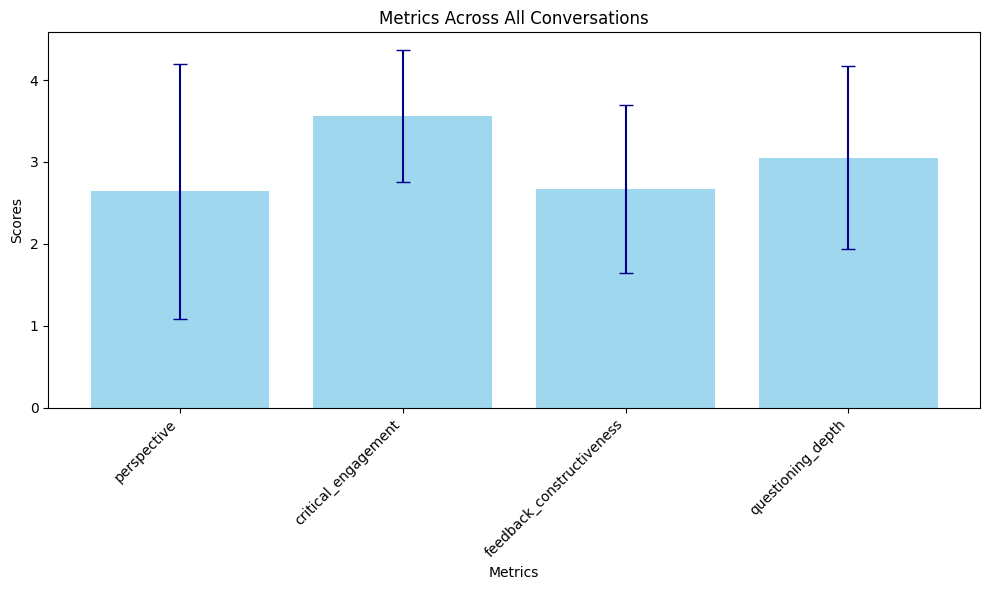

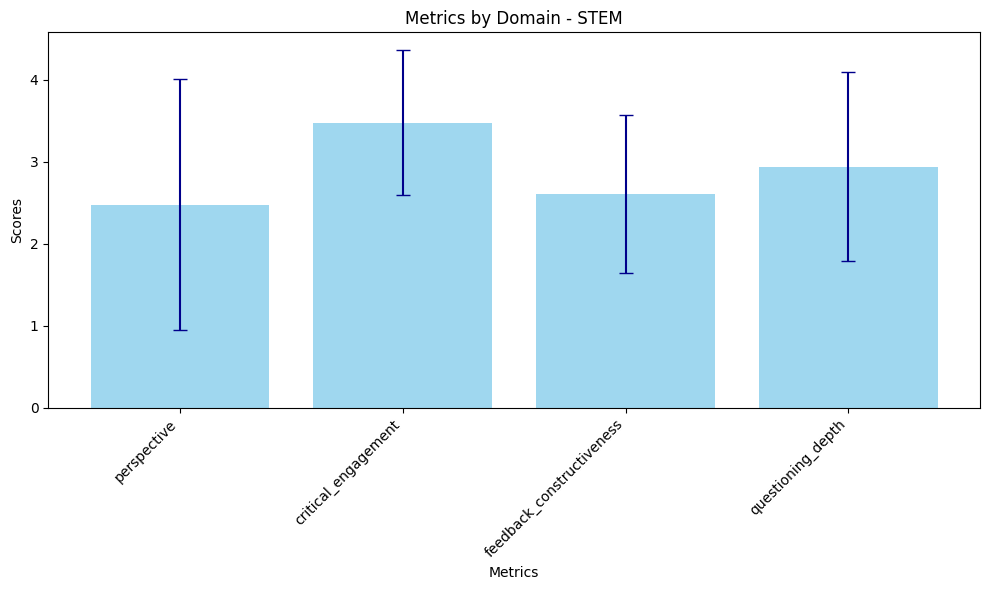

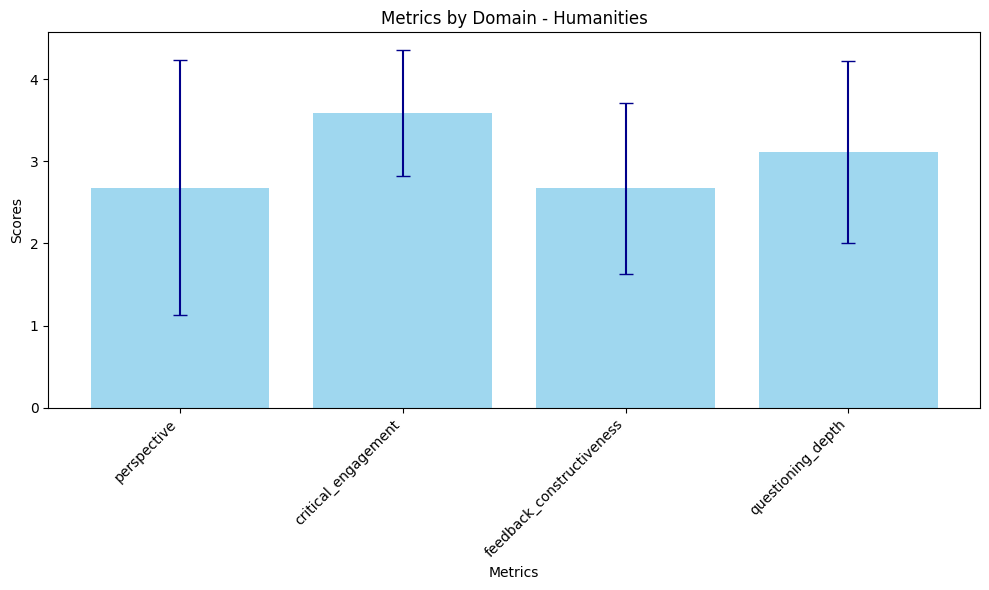

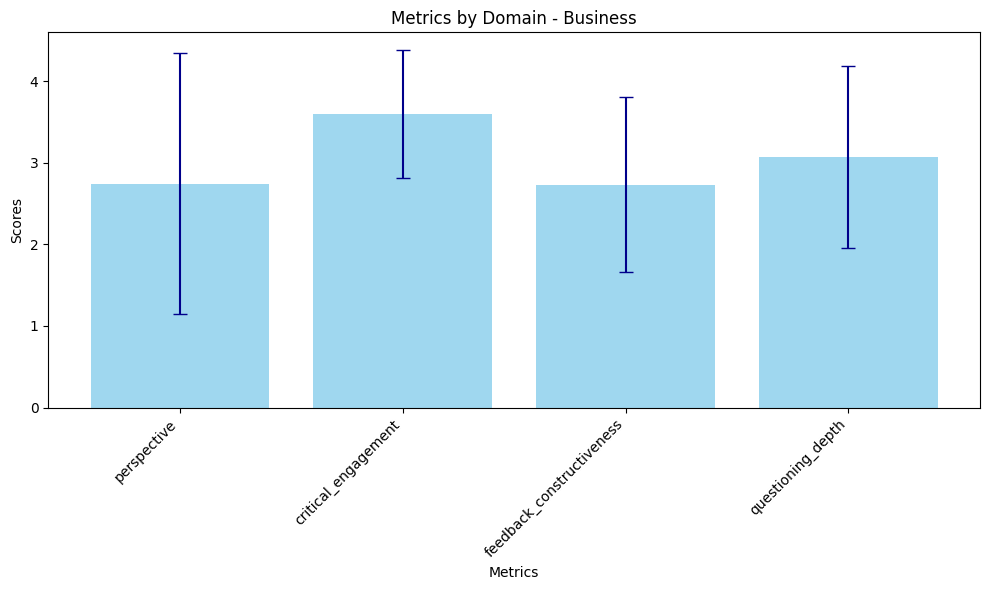

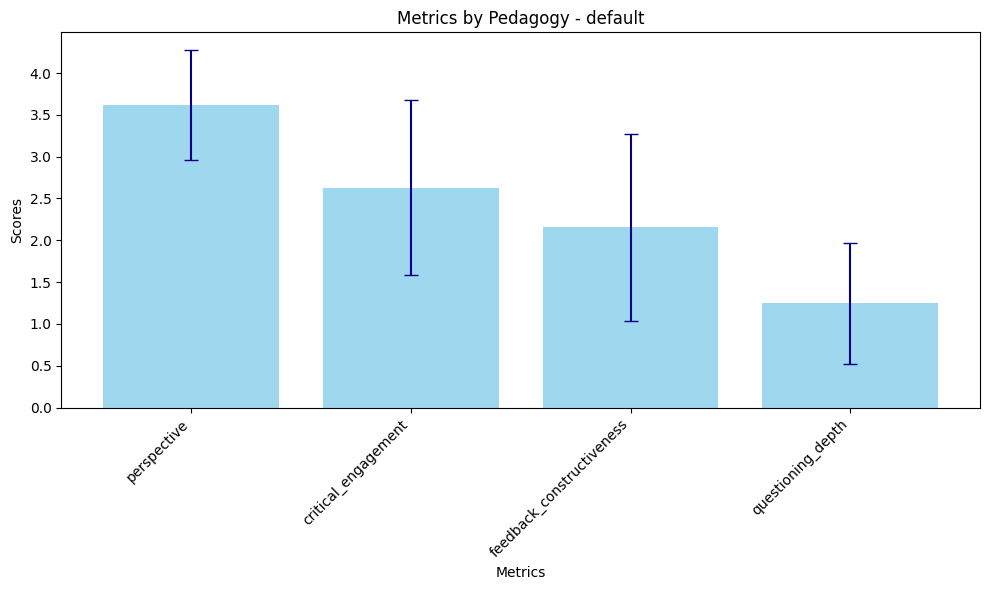

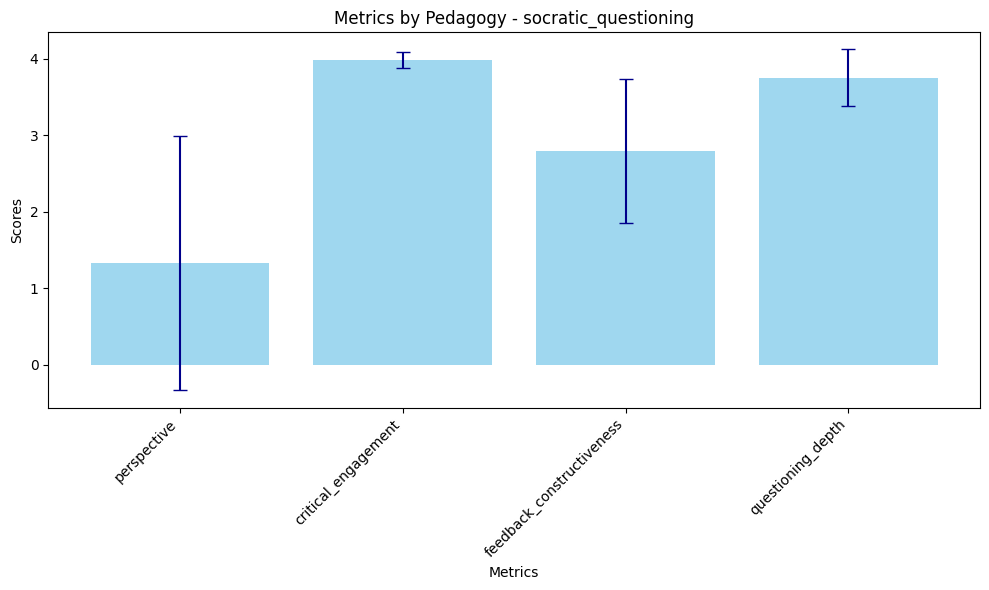

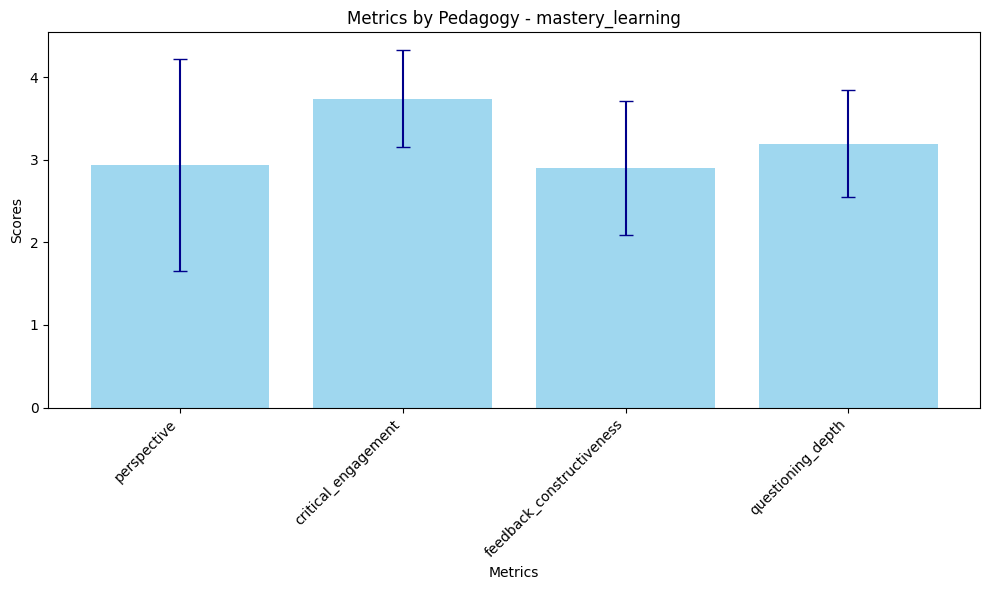

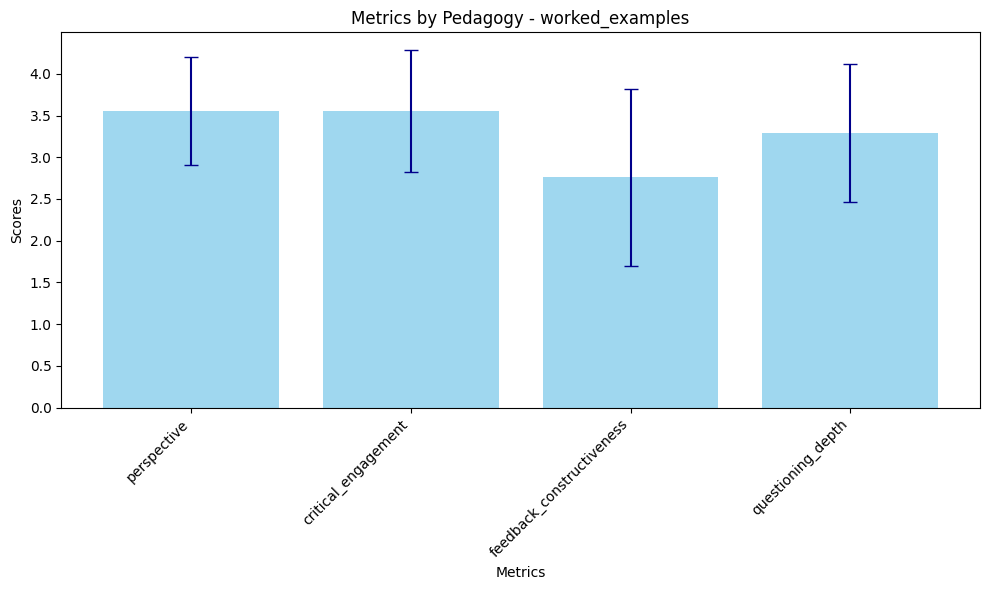

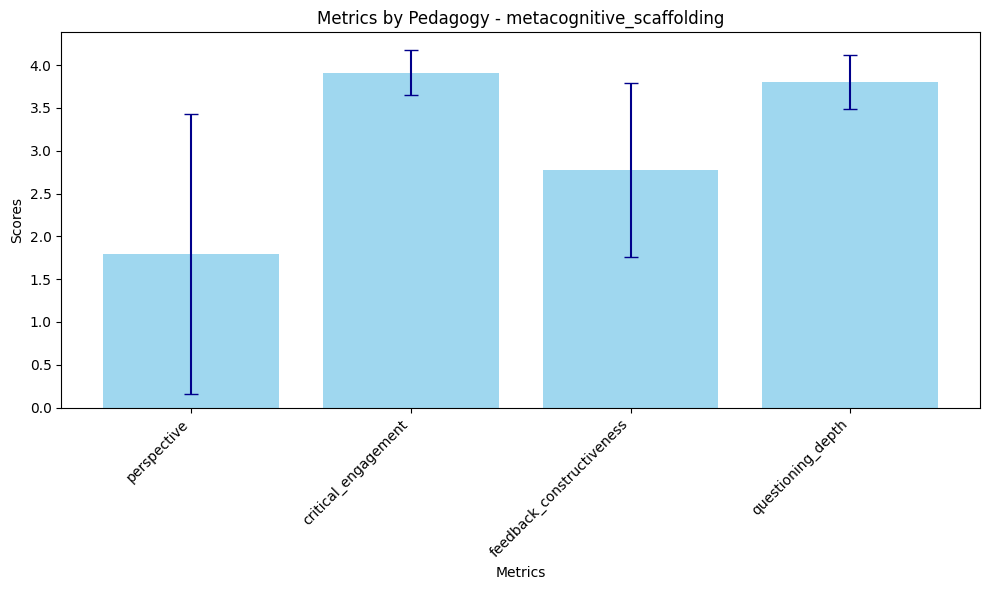

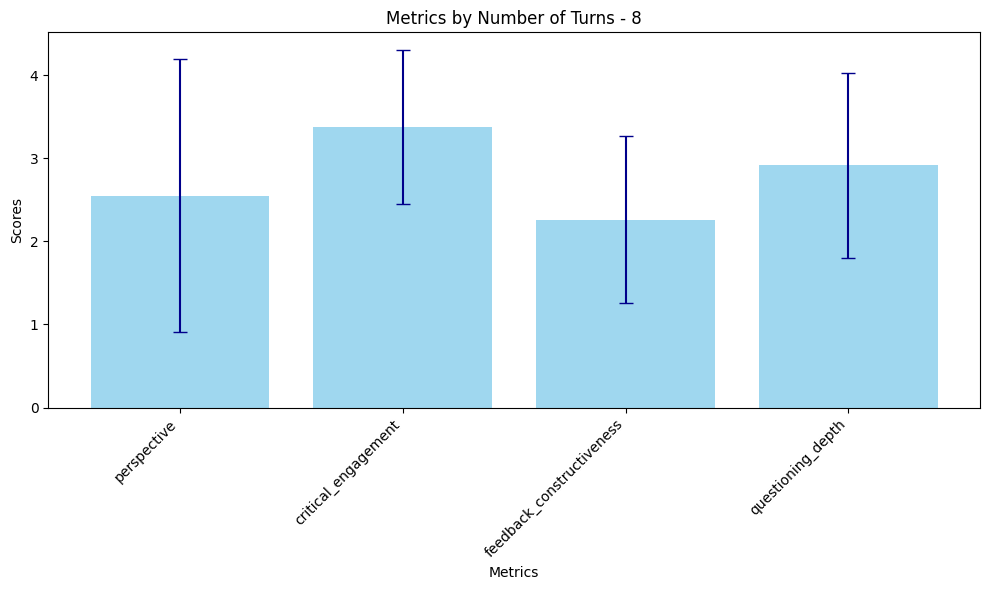

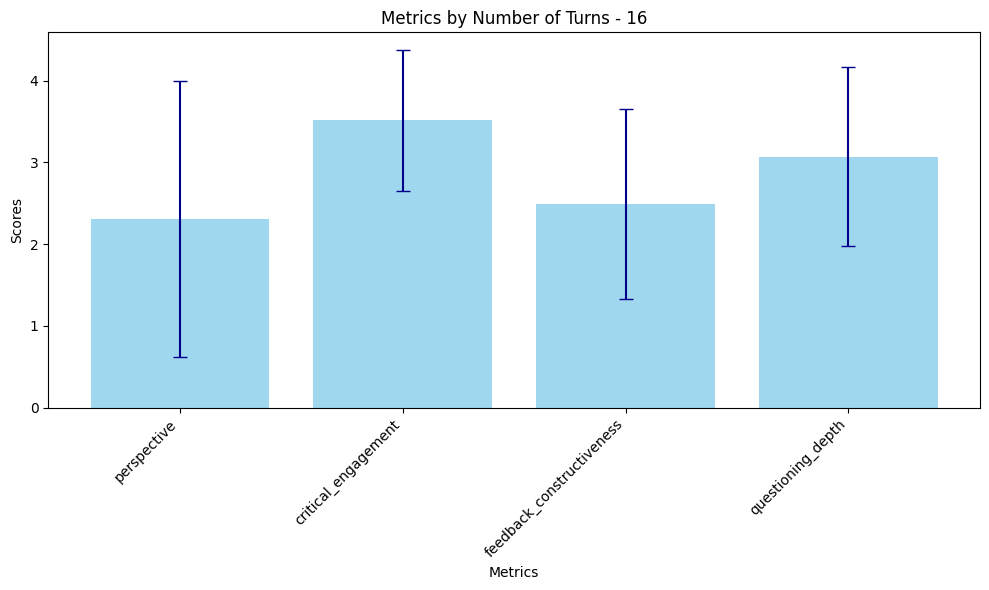

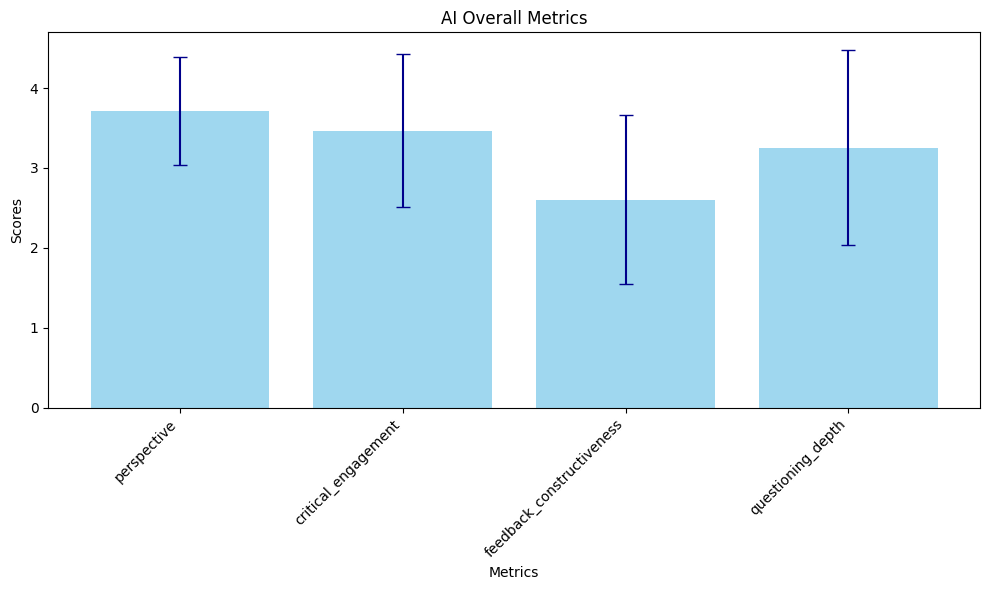

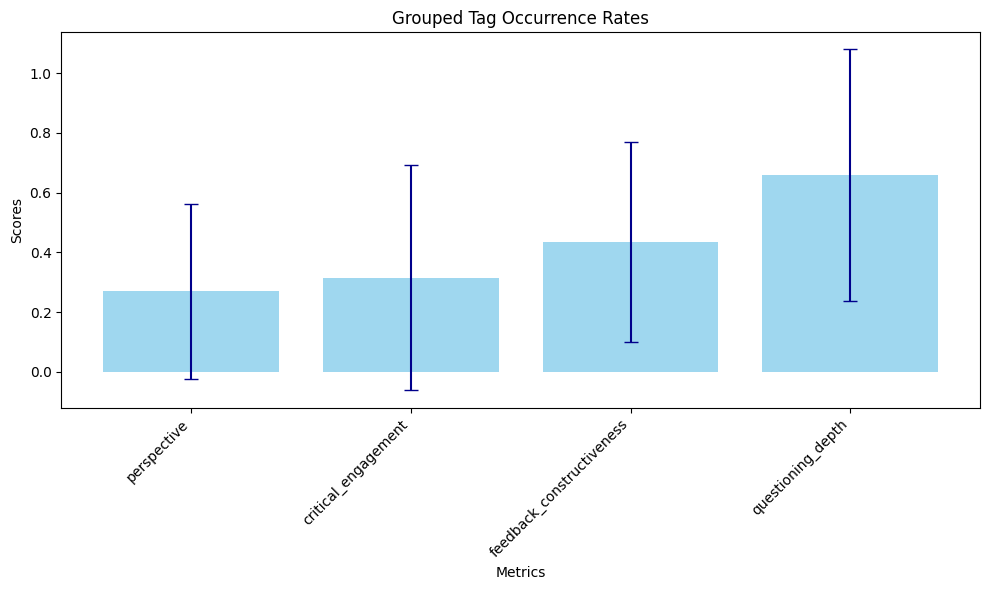

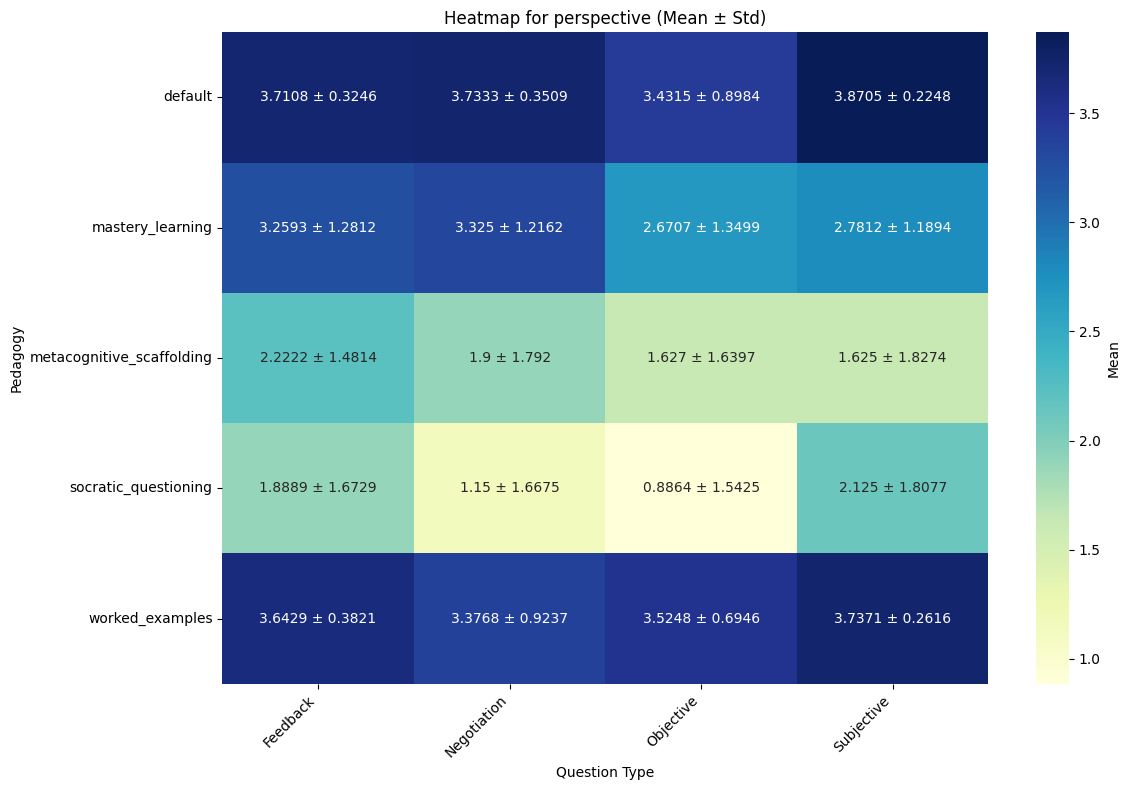

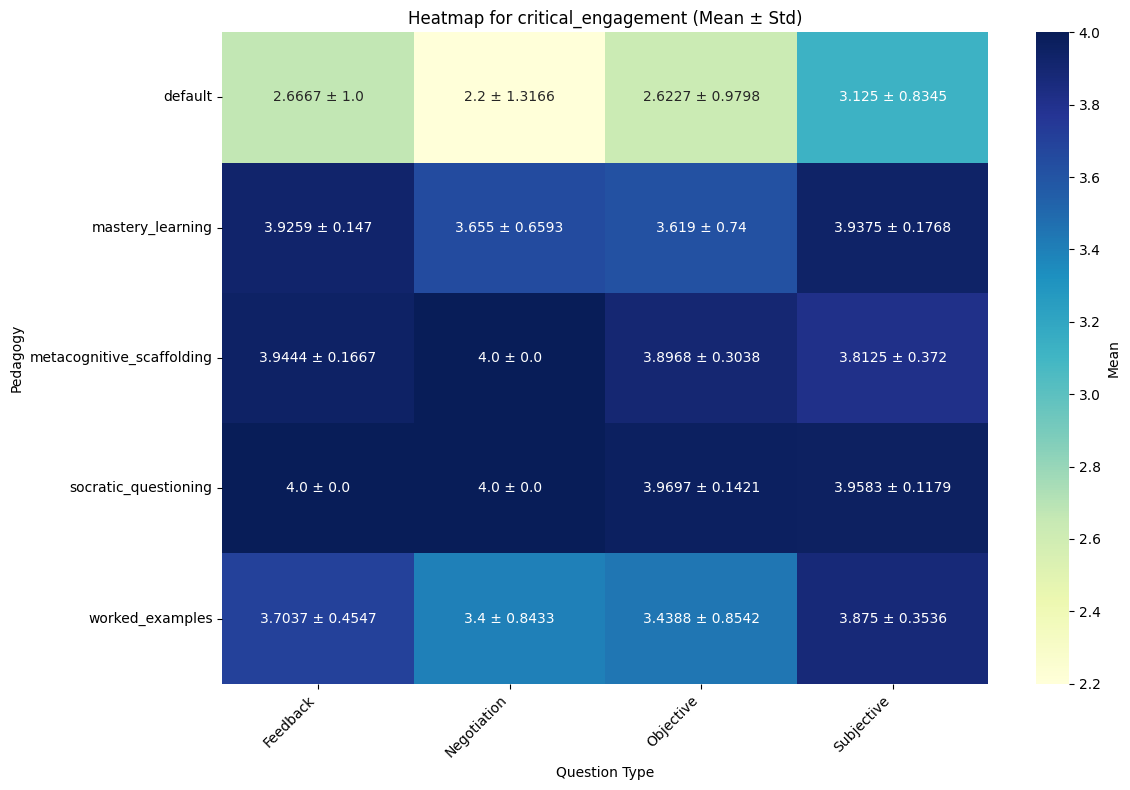

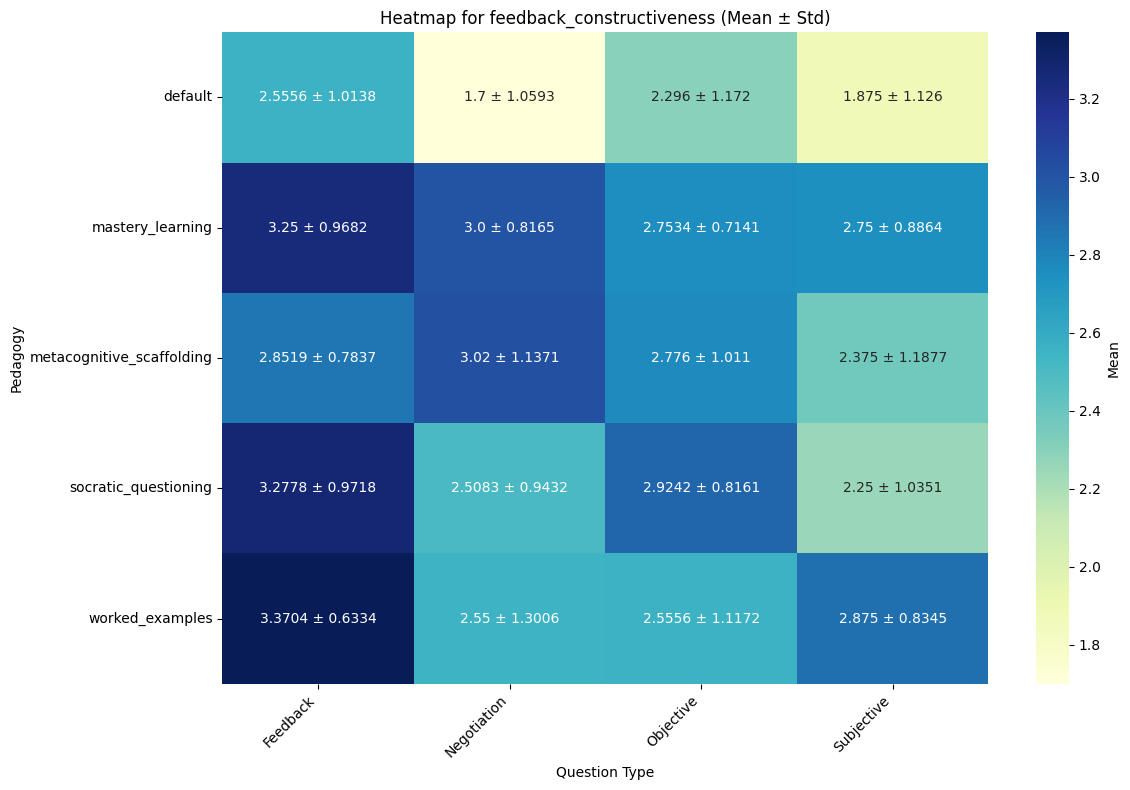

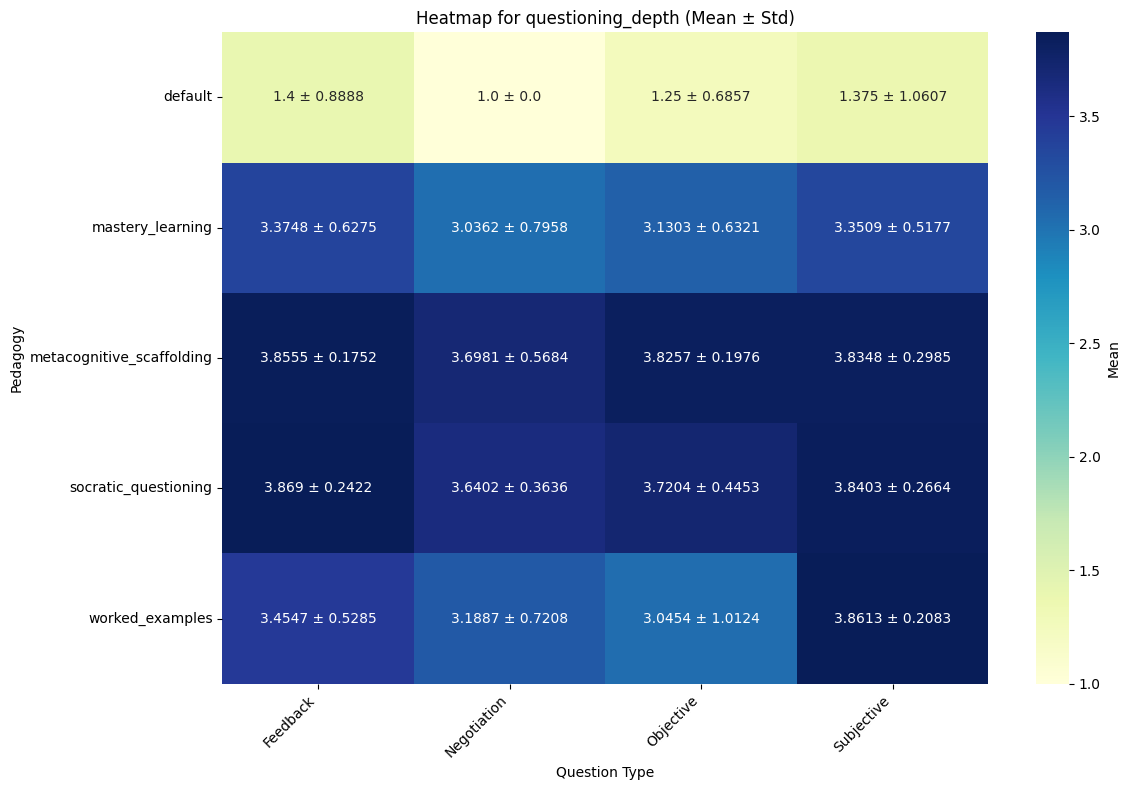

In [9]:
# Assuming master_dataset is loaded and the modified functions are defined

# 1. Mean and standard deviation for all the 4 metrics across all conversations
mean_std_all = compute_mean_std_metrics_all(master_dataset)
print(mean_std_all)
# Example output: {'perspective': (mean, std), 'critical_engagement': (mean, std), ...}

# 2. Domain-wise mean and std for the 4 metrics
mean_std_domain = compute_mean_std_metrics_domain(master_dataset)
print(mean_std_domain)
# Example output: {'STEM': {'perspective': (mean, std), ...}, ...}

# 3. Pedagogy-wise mean and std for the 4 metrics
mean_std_pedagogy = compute_mean_std_metrics_pedagogy(master_dataset)
print(mean_std_pedagogy)
# Example output: {'default': {'perspective': (mean, std), ...}, ...}

# 4. No_of_turns-wise mean and std for the 4 metrics
mean_std_turns = compute_mean_std_metrics_turns(master_dataset)
print(mean_std_turns)
# Example output: {8: {'perspective': (mean, std), ...}, ...}

# 5. Matrices of scores for intersection of question_type and pedagogy for each of the 4 metrics
metric_matrices = compute_metric_matrices(master_dataset)
print(metric_matrices)
# Example output: {'perspective': {'pedagogy1': {'qtype1': (mean, std), ...}, ...}, ...}

# 6. Mean and standard deviation of all ai_overall scores for the 4 metrics
mean_std_overall = compute_mean_std_ai_overall(master_dataset)
print(mean_std_overall)
# Example output: {'perspective': (mean, std), 'critical_engagement': (mean, std), ...}

# 7. Pearson correlation between the combined ai_mean scores and ai_overall scores across the 4 metrics
pearson_corr = compute_pearson_correlation(master_dataset)
print(pearson_corr)
# Example output: 0.6295

# 8. Mean and standard deviation of the occurrence of grouped tags in each conversation
mean_std_occurrence = compute_mean_std_occurrence(master_dataset)
print(mean_std_occurrence)
# Example output: {'perspective': (mean, std), 'critical_engagement': (mean, std), ...}

# 9. Visualize with bar plots
# For all conversations (function 1)
mean_std_all = compute_mean_std_metrics_all(master_dataset)
plot_bar_mean_std(mean_std_all, title='Metrics Across All Conversations')

# For grouped (functions 2,3,4)
mean_std_domain = compute_mean_std_metrics_domain(master_dataset)
plot_grouped_bar_mean_std(mean_std_domain, title_prefix='Metrics by Domain')

mean_std_pedagogy = compute_mean_std_metrics_pedagogy(master_dataset)
plot_grouped_bar_mean_std(mean_std_pedagogy, title_prefix='Metrics by Pedagogy')

mean_std_turns = compute_mean_std_metrics_turns(master_dataset)
plot_grouped_bar_mean_std(mean_std_turns, title_prefix='Metrics by Number of Turns')

# For overall (function 6)
mean_std_overall = compute_mean_std_ai_overall(master_dataset)
plot_bar_mean_std(mean_std_overall, title='AI Overall Metrics')

# For occurrence (function 8)
mean_std_occurrence = compute_mean_std_occurrence(master_dataset)
plot_bar_mean_std(mean_std_occurrence, title='Grouped Tag Occurrence Rates')

# 10. Heatmap for Question type & Pedagogy matrices (function 5)
metric_matrices = compute_metric_matrices(master_dataset)
plot_heatmap_matrices(metric_matrices, master_dataset)
# Generates 4 heatmaps, one per metric